In [39]:
import pandas_datareader as pdr
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

%matplotlib inline

In [40]:
start = datetime.datetime(1998,1,1)
end = datetime.datetime.now()

In [41]:
ff_df = pd.read_csv('data/fedfunds2.csv')
ff_df = ff_df[::-1]
ff_df['Date'] = pd.to_datetime(ff_df['Date'])
ff_df.set_index('Date')

,Rate
Date,
2020-01-29,1.55
2020-01-28,1.55
2020-01-27,1.55
2020-01-24,1.55
2020-01-23,1.55
...,...
1998-01-07,5.29
1998-01-06,5.35
1998-01-05,5.51


In [42]:
libor_df = pd.read_csv('data/libor1.csv')
libor_df = libor_df[::-1]
libor_df['Date'] = pd.to_datetime(libor_df['Date'])
libor_df.set_index('Date')

,Rate
Date,
2020-01-24,1.6595
2020-01-23,1.66088
2020-01-22,1.65938
2020-01-21,1.6595
2020-01-20,1.65338
...,...
1998-01-08,5.62891
1998-01-07,5.62891
1998-01-06,5.66797


In [43]:
mortgage_df = pd.read_csv('data/mortgage2.csv')
mortgage_df = mortgage_df[::-1]
mortgage_df['Date'] = pd.to_datetime(mortgage_df['Date'])
mortgage_df.set_index('Date')

,Rate
Date,
2020-01-01,3.51
2019-12-01,3.74
2019-11-01,3.68
2019-10-01,3.78
2019-09-01,3.64
...,...
1998-05-01,7.07
1998-04-01,7.15
1998-03-01,7.08


In [44]:
vacancy_df = pd.read_csv('data/vacancies2.csv')
vacancy_df = vacancy_df[::-1]
vacancy_df['Date'] = pd.to_datetime(vacancy_df['Date'])
vacancy_df.set_index('Date')

,Rate
Date,
2020-02-01,6.4
2020-01-01,6.4
2019-12-01,6.4
2019-11-01,6.4
2019-10-01,6.4
...,...
1999-01-01,8.2
1998-10-01,7.8
1998-07-01,8.2


In [45]:
AMT = pdr.get_data_yahoo('AMT', start, end)
AMT = AMT.resample('MS').mean()
AMT['Name'] = pd.Series()
AMT['Name'] = 'AMT'

CUBE = pdr.get_data_yahoo('CUBE', start, end)
CUBE = CUBE.resample('MS').mean()
CUBE['Name'] = pd.Series()
CUBE['Name'] = 'CUBE'

DEI = pdr.get_data_yahoo('DEI')
DEI = DEI.resample('MS').mean()
DEI['Name'] = pd.Series()
DEI['Name'] = 'DEI'

PLD = pdr.get_data_yahoo('PLD')
PLD = PLD.resample('MS').mean()
PLD['Name'] = pd.Series()
PLD['Name'] = 'PLD'

FR = pdr.get_data_yahoo('FR')
FR = FR.resample('MS').mean()
FR['Name'] = pd.Series()
FR['Name'] = 'FR'

MAA = pdr.get_data_yahoo('MAA')
MAA = MAA.resample('MS').mean()
MAA['Name'] = pd.Series()
MAA['Name'] = 'MAA'

MGP = pdr.get_data_yahoo('MGP')
MGP = MGP.resample('MS').mean().ffill()
MGP['Name'] = pd.Series()
MGP['Name'] = 'MGP'

MPW = pdr.get_data_yahoo('MPW')
MPW = MPW.resample('MS').mean()
MPW['Name'] = pd.Series()
MPW['Name'] = 'MPW'

WY = pdr.get_data_yahoo('WY')
WY = WY.resample('MS').mean()
WY['Name'] = pd.Series()
WY['Name'] = 'WY'

In [46]:
reit_df_list = [AMT, CUBE, DEI, PLD, FR, MAA, MGP, MPW, WY]
for reit in reit_df_list:
    reit.index = pd.to_datetime(reit.index)

In [47]:
all_reits_df = AMT.append([CUBE, DEI, PLD, FR, MAA, MGP, MPW, WY])
all_reits_df.to_csv('data/all_reits_dataframe.csv')

In [49]:
all_reits_df.drop(labels = ['High', 'Low', 'Open', 'Close', 'Volume'], axis = 1, inplace = True)

In [51]:
all_reits_df

,Adj Close,Name
Date,,
1998-02-01,14.991437,AMT
1998-03-01,15.060070,AMT
1998-04-01,19.341473,AMT
1998-05-01,18.561342,AMT
1998-06-01,19.285911,AMT
...,...,...
2019-09-01,27.095295,WY
2019-10-01,27.676660,WY
2019-11-01,29.155218,WY


In [52]:
reit_df_name_list = ['AMT', 'CUBE', 'DEI', 'PLD', 'FR', 'MAA', 'MGP', 'MPW', 'WY']
reit_df_dict = {}
for name in reit_df_name_list:
    df = all_reits_df.loc[all_reits_df.Name == name]
    df.drop(labels = 'Name', axis = 1,inplace = True)
    reit_df_dict[name] = df

In [53]:
def plot_reit_ts(df_dict):
    for key in df_dict.keys():
        plt.style.use('ggplot')
        df_dict[key].plot(figsize = (12,5), layout = (5, 2))
        plt.xlabel('Month')
        plt.ylabel('Adjusted Close Price')
        plt.title(f'{key} Adjusted Closing Price Over Time')
        plt.tight_layout()
        plt.show();

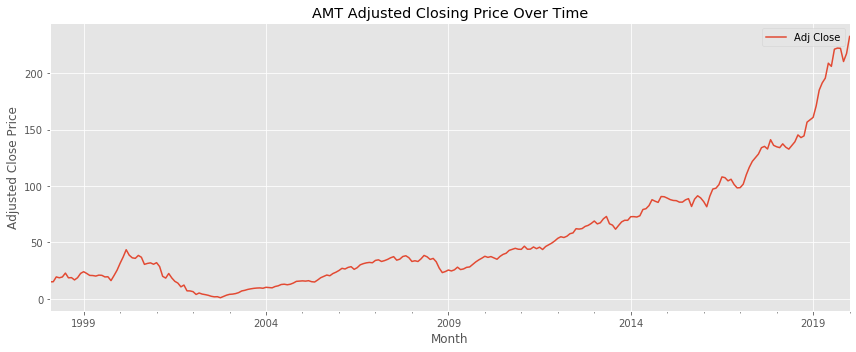

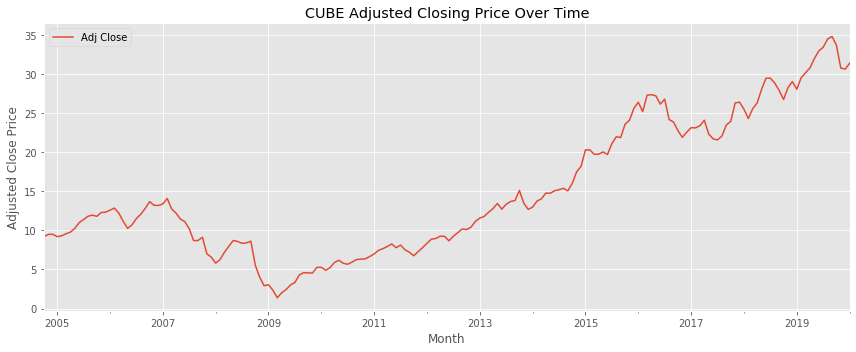

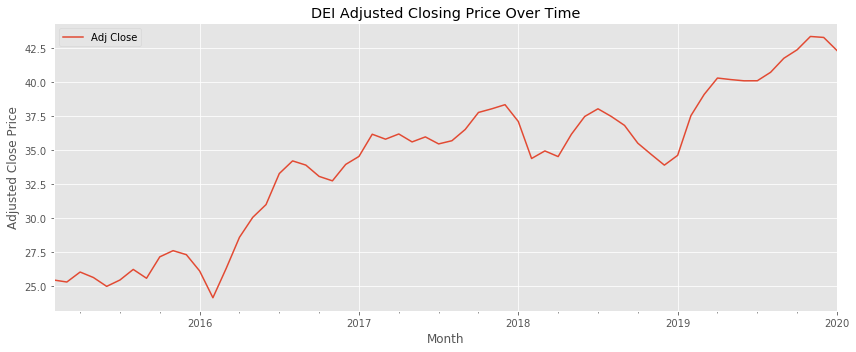

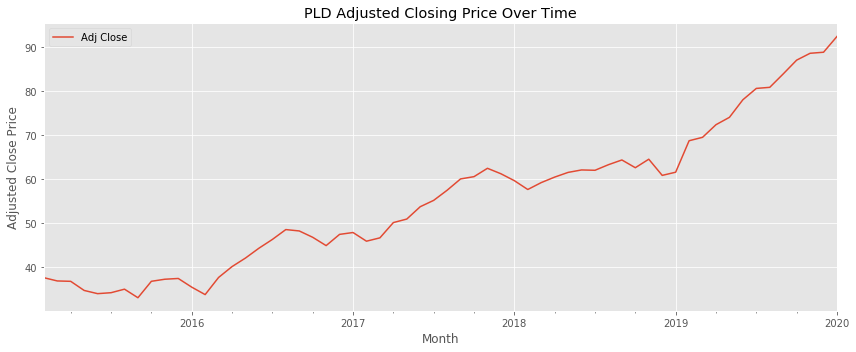

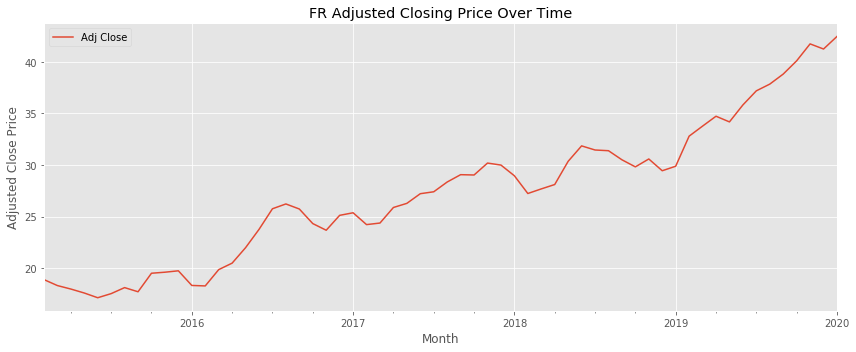

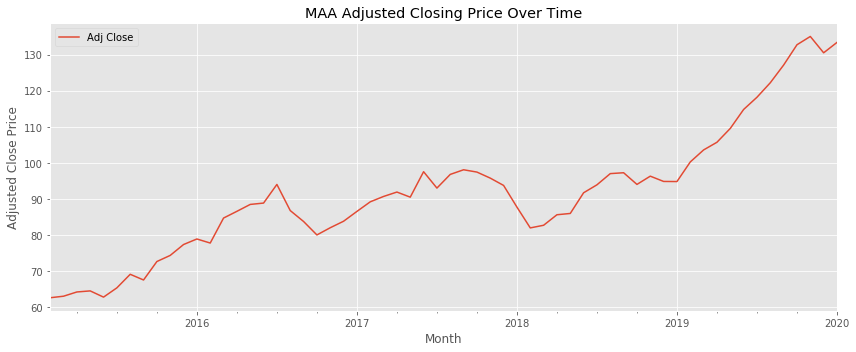

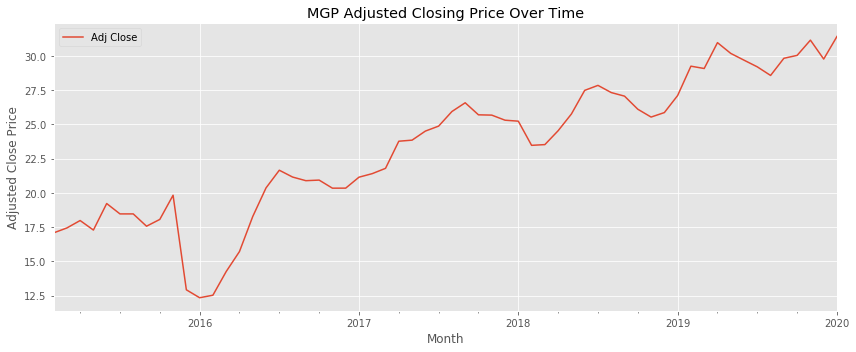

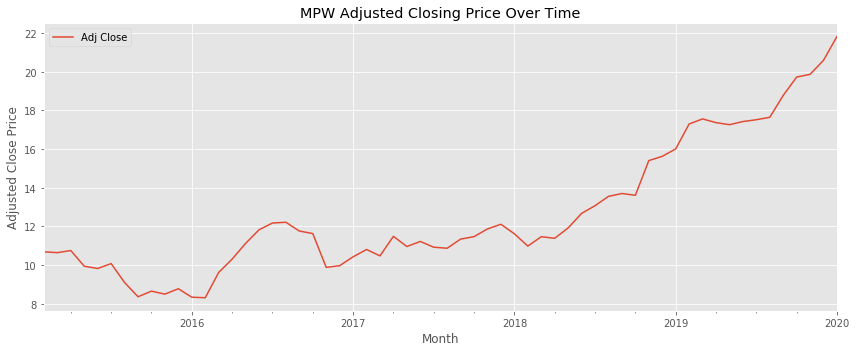

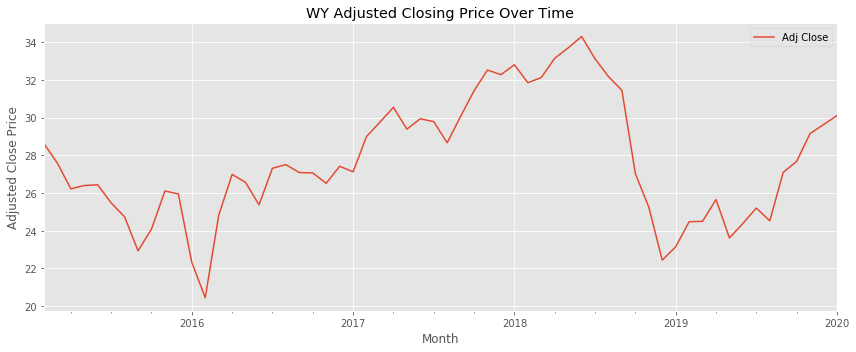

In [54]:
plot_reit_ts(reit_df_dict)

In [55]:
def decomposition(df_dict):
    for key in df_dict.keys():
        ts = df_dict[key]
        decomposition = seasonal_decompose(np.log(ts))
        trend = decomposition.trend
        seasonal = decomposition.seasonal
        residual = decomposition.resid
    
        # Plot with subplots
        plt.figure(figsize=(10,6))
        plt.subplot(411)
        plt.plot(np.log(ts), label='Original', color="blue")
        plt.legend(loc='best')
        plt.title(f'{key}')
        plt.subplot(412)
        plt.plot(trend, label='Trend', color="blue")
        plt.legend(loc='best')
        plt.subplot(413)
        plt.plot(seasonal,label='Seasonality', color="blue")
        plt.legend(loc='best')
        plt.subplot(414)
        plt.plot(residual, label='Residuals', color="blue")
        plt.legend(loc='best')
        plt.tight_layout()
        
        

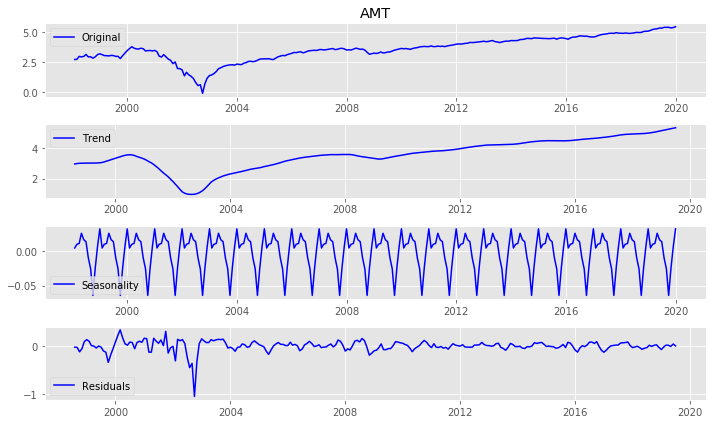

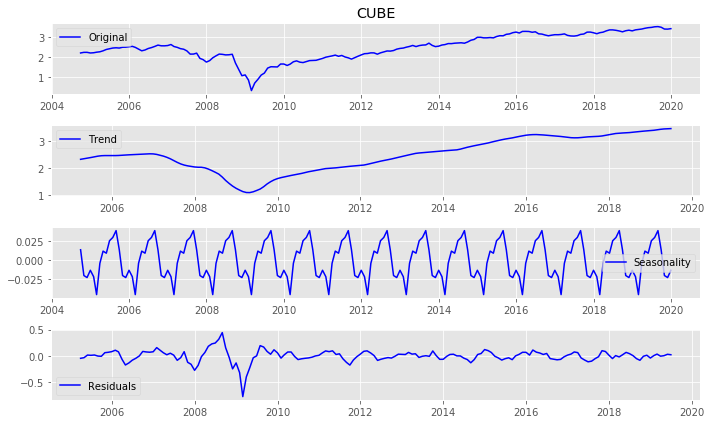

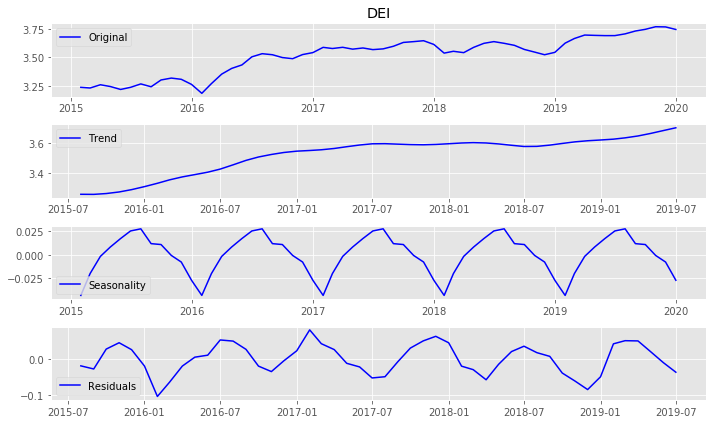

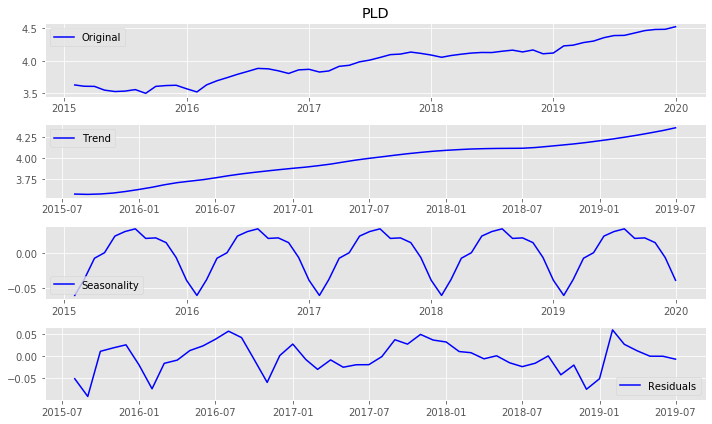

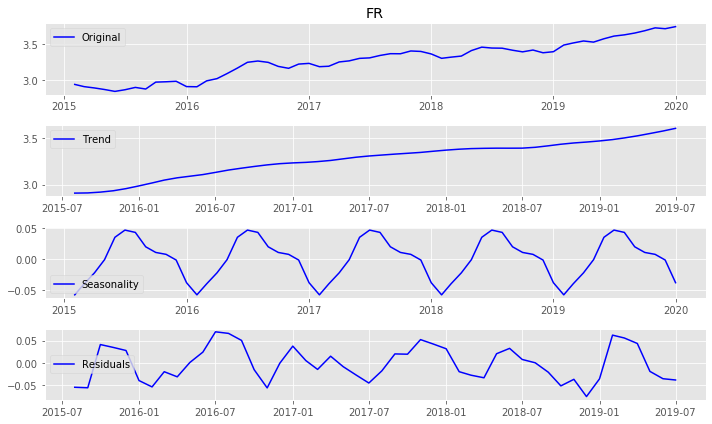

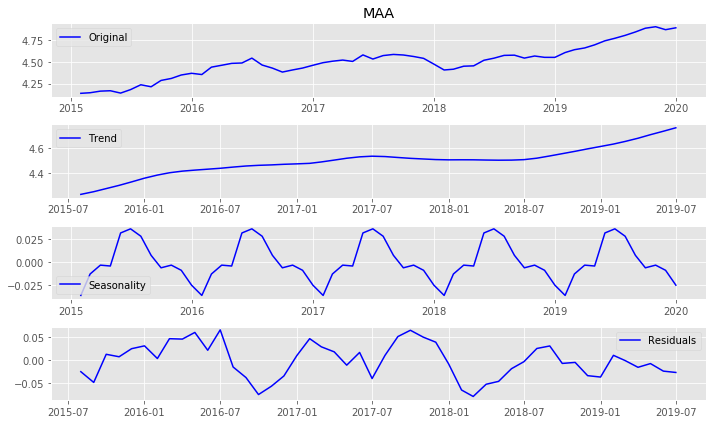

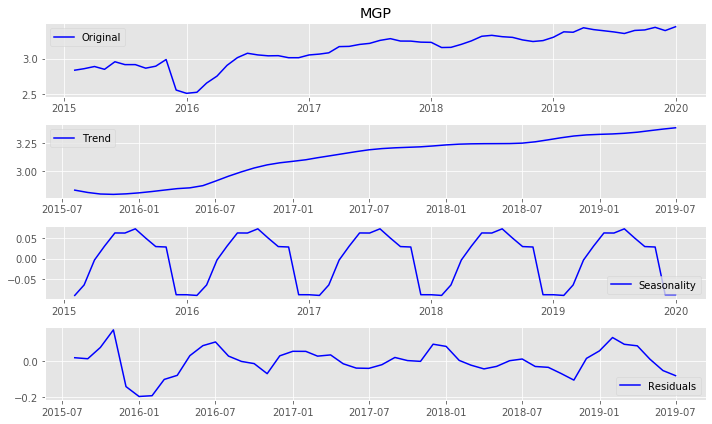

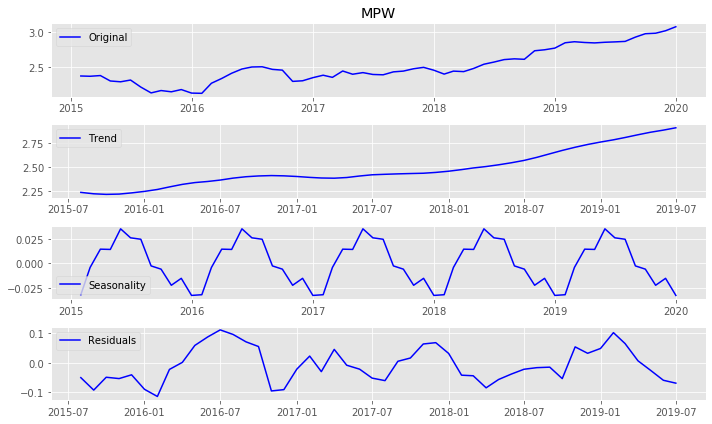

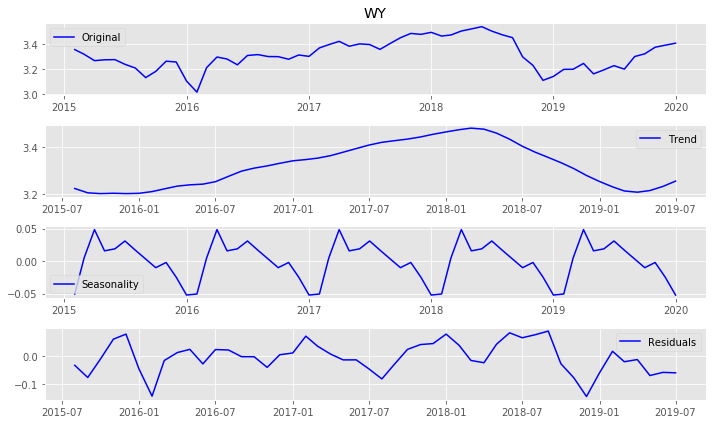

In [56]:
decomposition(reit_df_dict)

In [57]:
def differencing(df_dict):
    diff_df_dict = {}
    for key in df_dict.keys():
        diff_df_dict[key] = df_dict[key].diff(periods = 1).dropna()
        
    return diff_df_dict

In [58]:
#First order difference
diff1_reit_df_dict = differencing(reit_df_dict)

In [59]:
def dickey_fuller(df_dict):
    dftest_pvalue_dict = {}
    for key in df_dict.keys():
        dftest = adfuller(df_dict[key]['Adj Close'])
        dfoutput = pd.Series(dftest[0:4], index = ['Test Stat', 'p-value', '# lags used', '# Observations used'])
        dftest_pvalue_dict[key] = dftest[1]
        
    print(f'{((np.array(list(dftest_pvalue_dict.values())) < 0.05).sum() / len(df_dict)) * 100} % pass Dickey Fuller Test')

In [60]:
dickey_fuller(diff1_reit_df_dict)

100.0 % pass Dickey Fuller Test


In [61]:
def plot_partial_autocorrelation(df_dict):
    for key in df_dict.keys():
        plot_pacf(df_dict[key], lags = 12)
        plt.title(f'PACF - {key}')
        plt.show();

In [62]:
def plot_autocorrelation(df_dict):
    for key in df_dict.keys():
        plot_acf(df_dict[key], lags = 12)
        plt.title(f'ACF - {key}')
        plt.show();

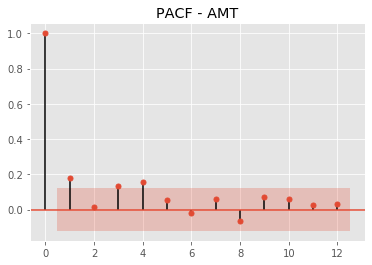

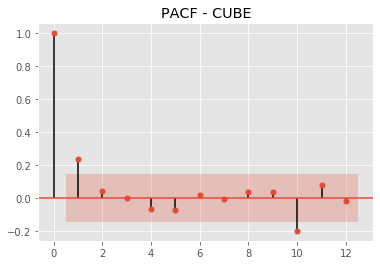

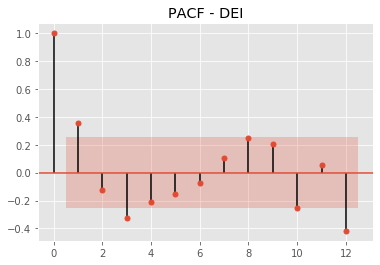

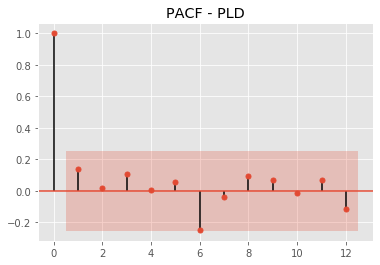

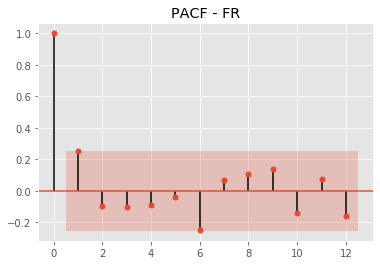

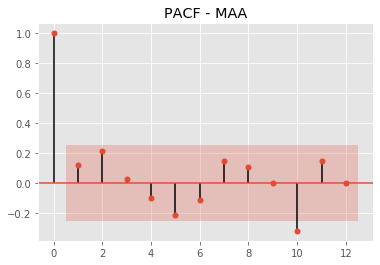

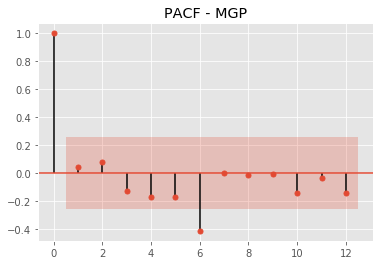

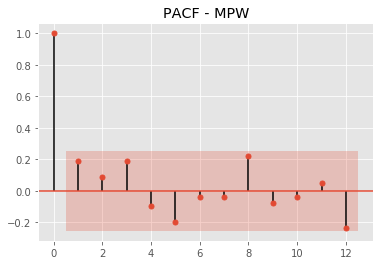

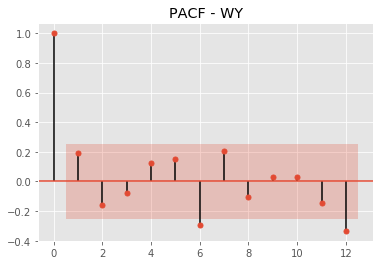

In [63]:
plot_partial_autocorrelation(diff1_reit_df_dict)

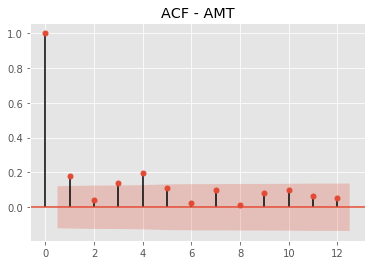

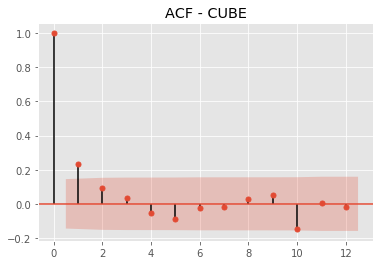

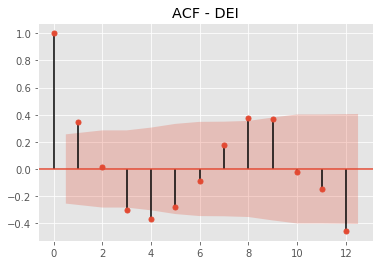

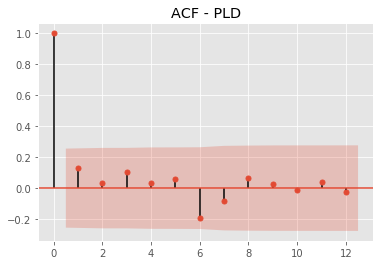

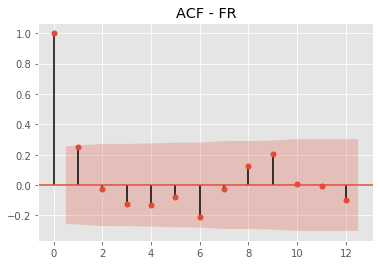

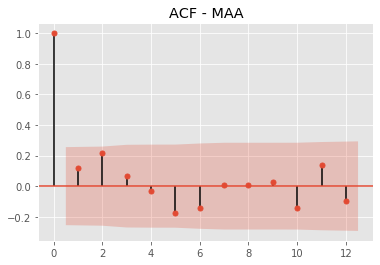

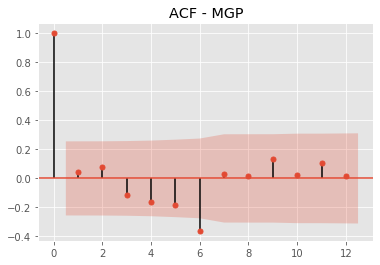

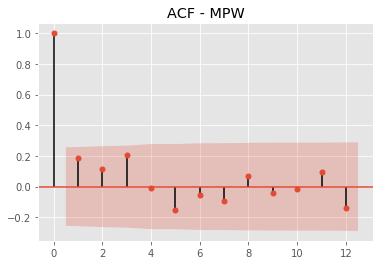

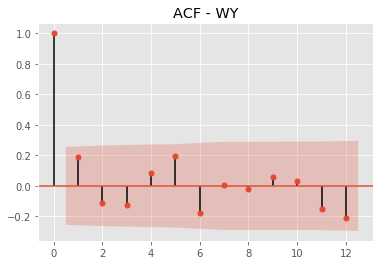

In [64]:
plot_autocorrelation(diff1_reit_df_dict)

In [69]:
best_parameters1 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters1[key] = ()
    
best_parameters1['AMT'] = (3,1,3)
best_parameters1['CUBE'] = (2,1,1)
best_parameters1['DEI'] = (3,1,3)
best_parameters1['PLD'] = (0,1,0)
best_parameters1['FR'] = (1,1,0)
best_parameters1['MAA'] = (1,1,0)
best_parameters1['MGP'] = (1,1,1)
best_parameters1['MPW'] = (0,1,0)
best_parameters1['WY'] = (2,1,0)

AMT Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                  264
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -669.403
Date:                Sun, 02 Feb 2020   AIC                           1354.806
Time:                        11:49:56   BIC                           1383.261
Sample:                    02-01-1998   HQIC                          1366.247
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0029      0.002      1.634      0.102      -0.001       0.006
ar.L1          0.7768      0.253      3.066      0.002       0.280       1.273
ar.L2         -0.5383      0.291     -1.

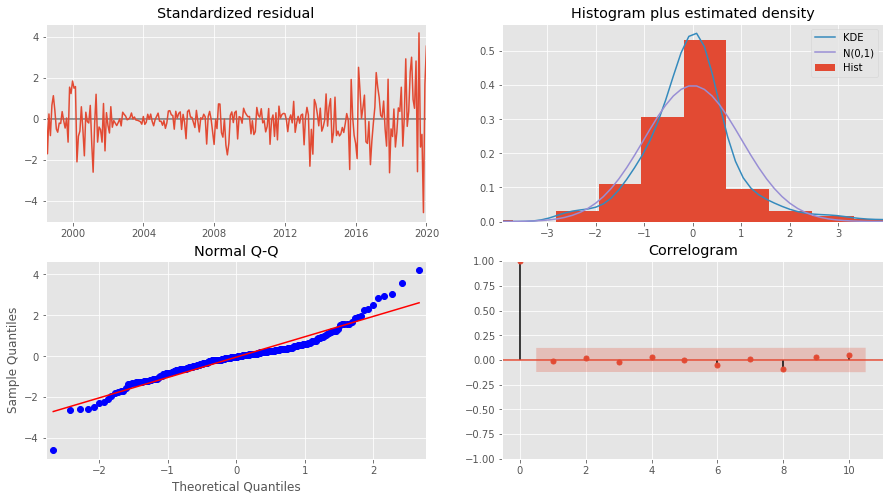

---------------------------------------------------------------
CUBE Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                  184
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -220.514
Date:                Sun, 02 Feb 2020   AIC                            451.027
Time:                        11:49:57   BIC                            467.020
Sample:                    10-01-2004   HQIC                           457.511
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0014      0.002      0.561      0.575      -0.003       0.006
ar.L1         -0.0113      1.895     -0.006      0.995

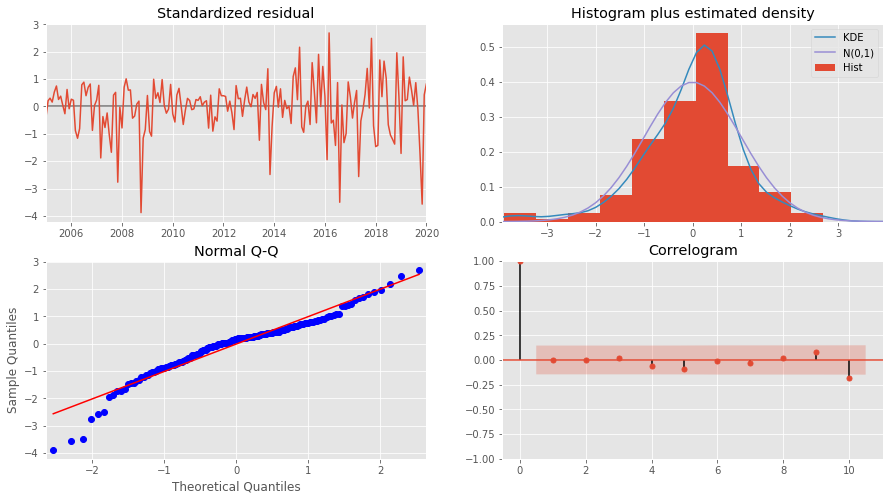

---------------------------------------------------------------
DEI Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(3, 1, 3)   Log Likelihood                 -69.480
Date:                Sun, 02 Feb 2020   AIC                            154.960
Time:                        11:49:58   BIC                            171.018
Sample:                    02-01-2015   HQIC                           161.170
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0067      0.005      1.485      0.138      -0.002       0.016
ar.L1          0.5930      0.168      3.533      0.000 

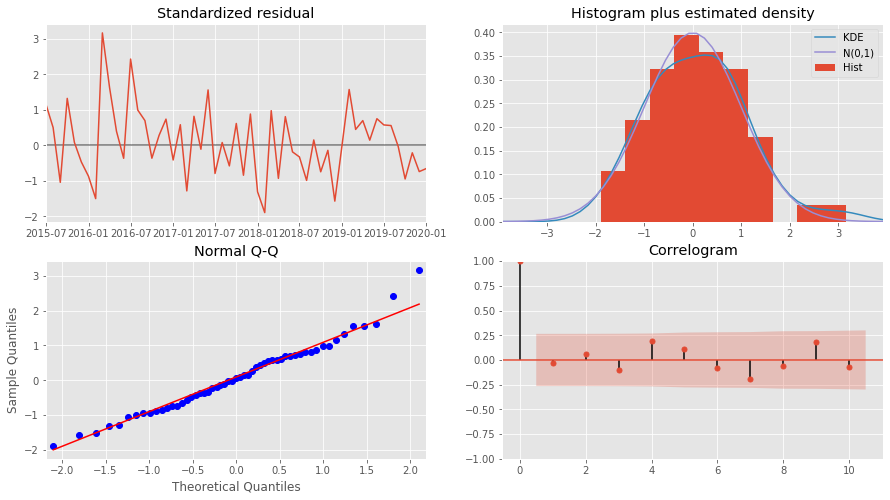

---------------------------------------------------------------
PLD Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -119.943
Date:                Sun, 02 Feb 2020   AIC                            243.885
Time:                        11:49:59   BIC                            248.006
Sample:                    02-01-2015   HQIC                           245.491
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0317      0.007      4.530      0.000       0.018       0.045
sigma2         3.6622      0.612      5.981      0.000 

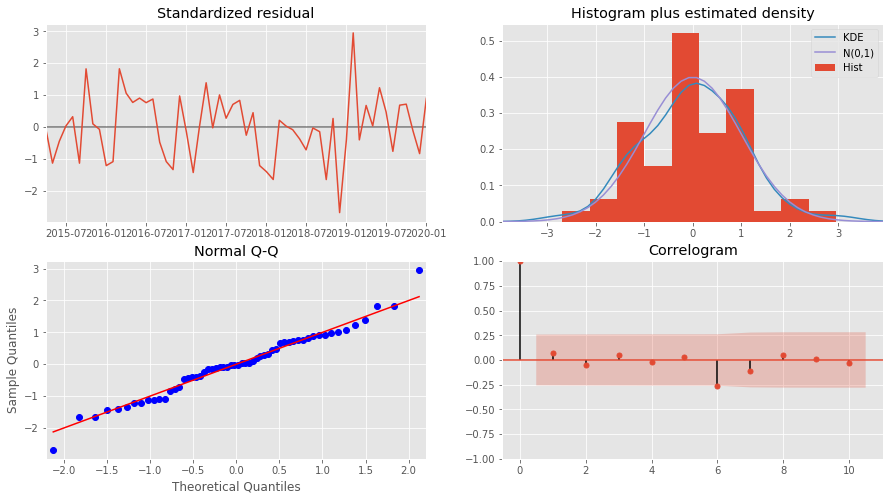

---------------------------------------------------------------
FR Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -80.406
Date:                Sun, 02 Feb 2020   AIC                            166.812
Time:                        11:50:00   BIC                            172.993
Sample:                    02-01-2015   HQIC                           169.220
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0101      0.004      2.647      0.008       0.003       0.018
ar.L1          0.2290      0.162      1.411      0.158  

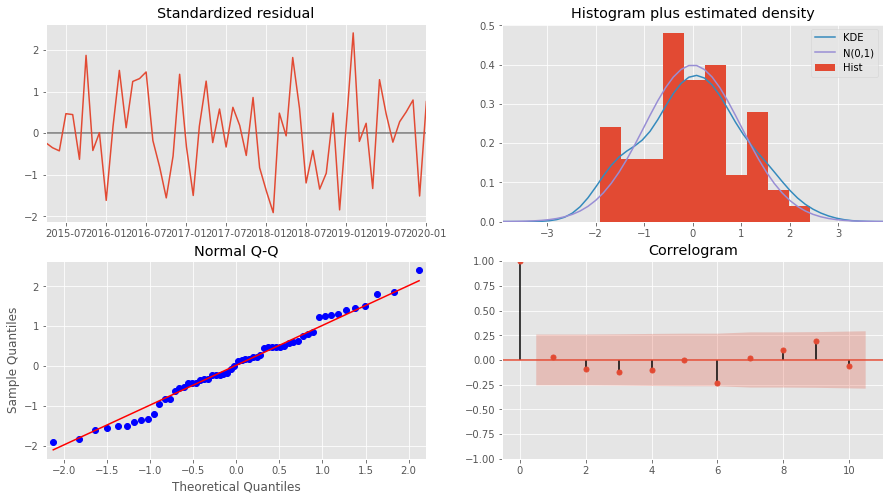

---------------------------------------------------------------
MAA Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -149.996
Date:                Sun, 02 Feb 2020   AIC                            305.992
Time:                        11:50:01   BIC                            312.174
Sample:                    02-01-2015   HQIC                           308.400
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0318      0.014      2.332      0.020       0.005       0.058
ar.L1          0.1143      0.125      0.914      0.361 

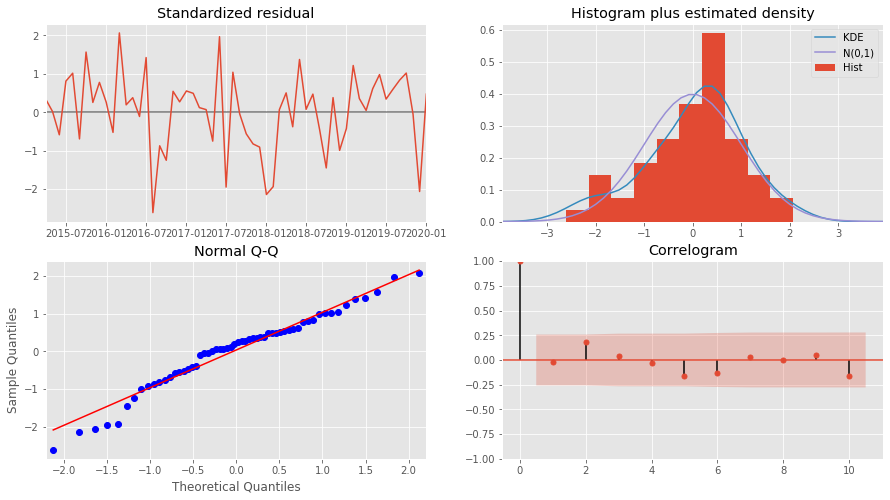

---------------------------------------------------------------
MGP Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -99.330
Date:                Sun, 02 Feb 2020   AIC                            206.661
Time:                        11:50:02   BIC                            214.833
Sample:                    02-01-2015   HQIC                           209.837
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0112      0.015      0.730      0.466      -0.019       0.041
ar.L1         -0.6311      1.555     -0.406      0.685 

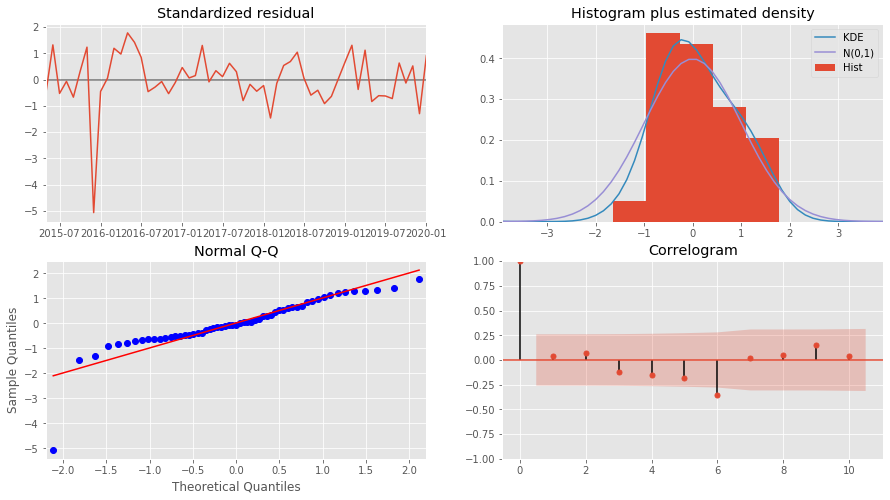

---------------------------------------------------------------
MPW Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -50.098
Date:                Sun, 02 Feb 2020   AIC                            104.197
Time:                        11:50:03   BIC                            108.317
Sample:                    02-01-2015   HQIC                           105.802
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0078      0.002      3.368      0.001       0.003       0.012
sigma2         0.3294      0.049      6.757      0.000 

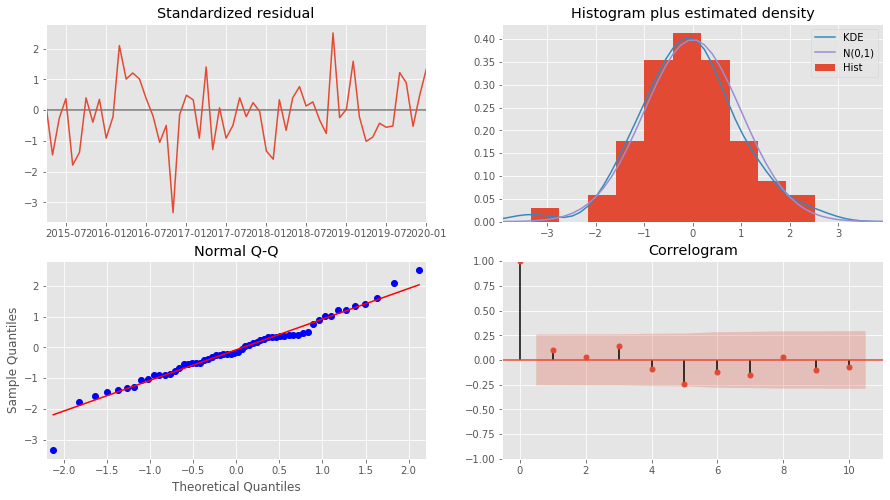

---------------------------------------------------------------
WY Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -101.681
Date:                Sun, 02 Feb 2020   AIC                            211.362
Time:                        11:50:04   BIC                            219.534
Sample:                    02-01-2015   HQIC                           214.538
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0019      0.006      0.302      0.763      -0.011       0.015
ar.L1          0.2075      0.186      1.113      0.266  

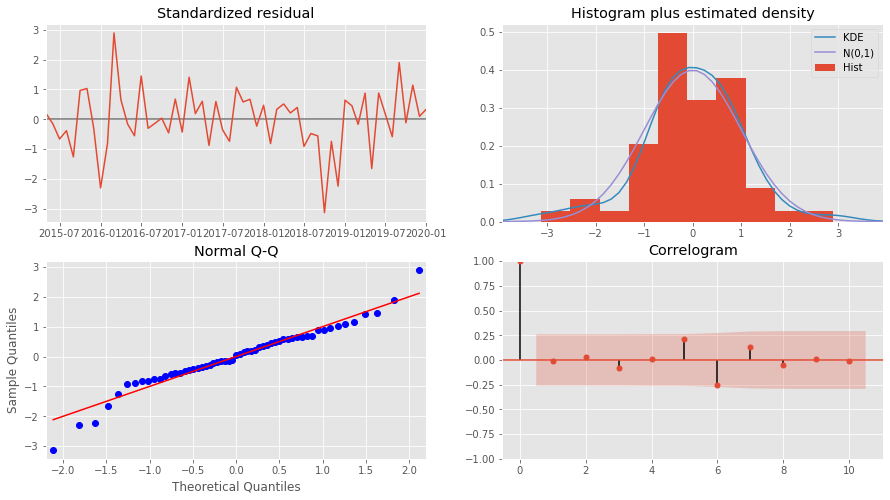

---------------------------------------------------------------


In [70]:
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters1[key], 
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')

In [75]:
best_parameters2 = {}
for key in diff1_reit_df_dict.keys():
    best_parameters2[key] = ()
    
best_parameters2['AMT'] = (3,1,2)
best_parameters2['CUBE'] = (1,1,1)
best_parameters2['DEI'] = (2,1,2)
best_parameters2['PLD'] = (1,1,0)
best_parameters2['FR'] = (2,1,0)
best_parameters2['MAA'] = (0,1,0)
best_parameters2['MGP'] = (0,1,1)
best_parameters2['MPW'] = (1,1,0)
best_parameters2['WY'] = (1,1,0)

AMT Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                  264
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -668.671
Date:                Sun, 02 Feb 2020   AIC                           1351.343
Time:                        12:13:09   BIC                           1376.267
Sample:                    02-01-1998   HQIC                          1361.363
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0052      0.001      4.827      0.000       0.003       0.007
ar.L1          1.1771      0.056     21.107      0.000       1.068       1.286
ar.L2         -1.0536      0.059    -17.

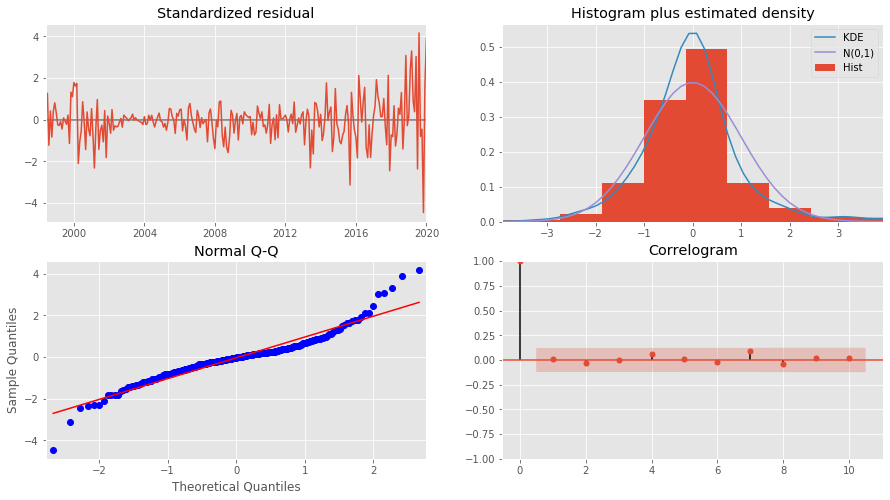

---------------------------------------------------------------
CUBE Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                  184
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -220.495
Date:                Sun, 02 Feb 2020   AIC                            448.991
Time:                        12:13:10   BIC                            461.785
Sample:                    10-01-2004   HQIC                           454.178
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0010      0.001      1.337      0.181      -0.000       0.002
ar.L1          0.3360      0.312      1.076      0.282

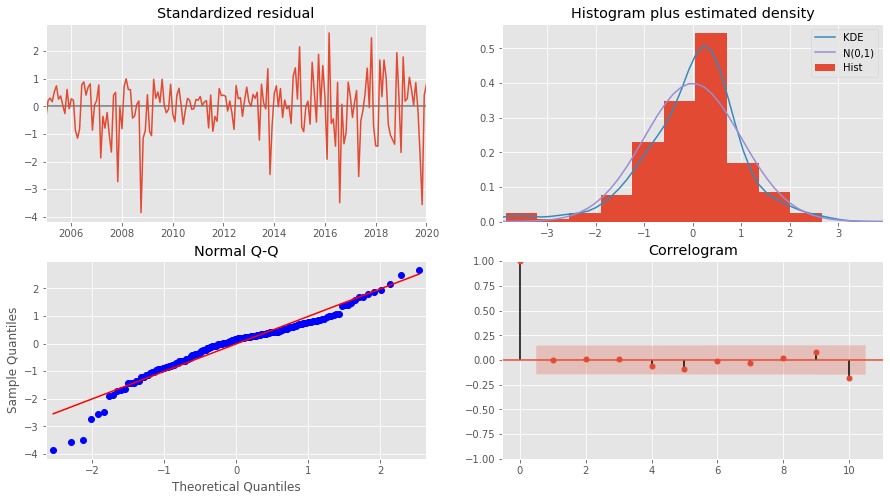

---------------------------------------------------------------
DEI Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -71.406
Date:                Sun, 02 Feb 2020   AIC                            154.812
Time:                        12:13:11   BIC                            166.964
Sample:                    02-01-2015   HQIC                           159.523
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0036      0.002      1.539      0.124      -0.001       0.008
ar.L1          1.4330      0.035     40.557      0.000 

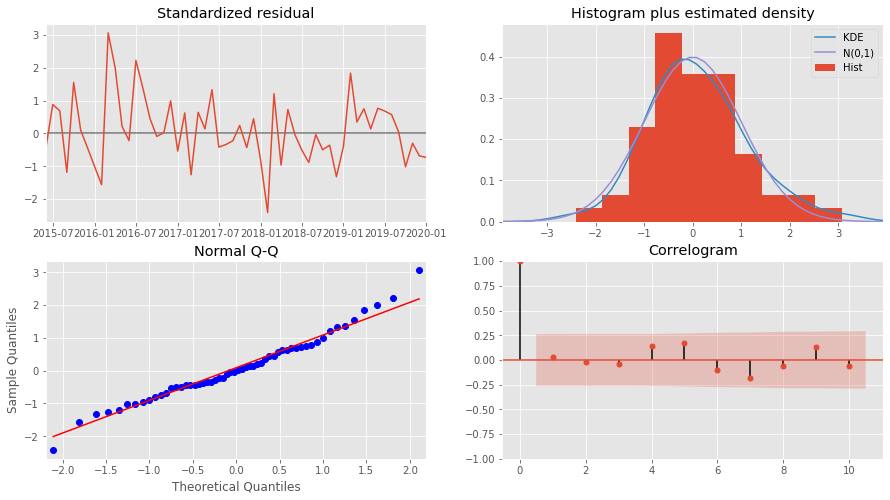

---------------------------------------------------------------
PLD Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -119.799
Date:                Sun, 02 Feb 2020   AIC                            245.598
Time:                        12:13:12   BIC                            251.779
Sample:                    02-01-2015   HQIC                           248.005
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0296      0.008      3.743      0.000       0.014       0.045
ar.L1          0.0707      0.176      0.401      0.688 

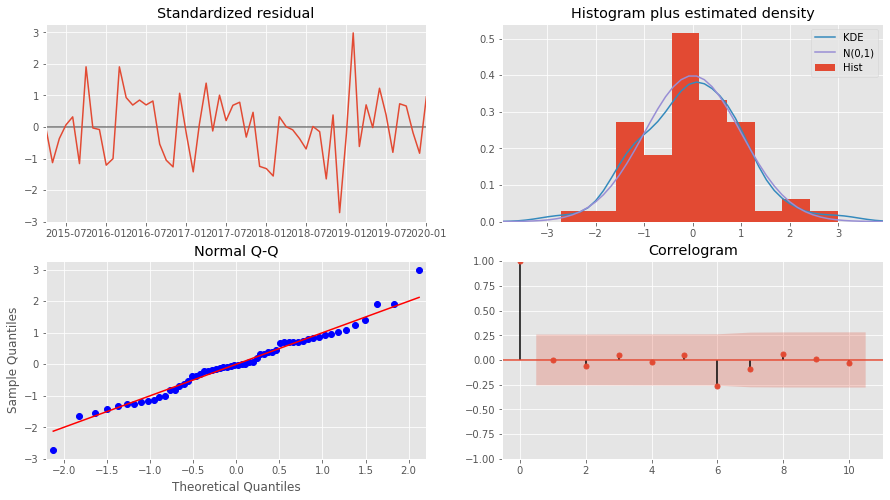

---------------------------------------------------------------
FR Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(2, 1, 0)   Log Likelihood                 -79.045
Date:                Sun, 02 Feb 2020   AIC                            166.091
Time:                        12:13:12   BIC                            174.263
Sample:                    02-01-2015   HQIC                           169.267
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0114      0.004      2.948      0.003       0.004       0.019
ar.L1          0.2576      0.171      1.505      0.132  

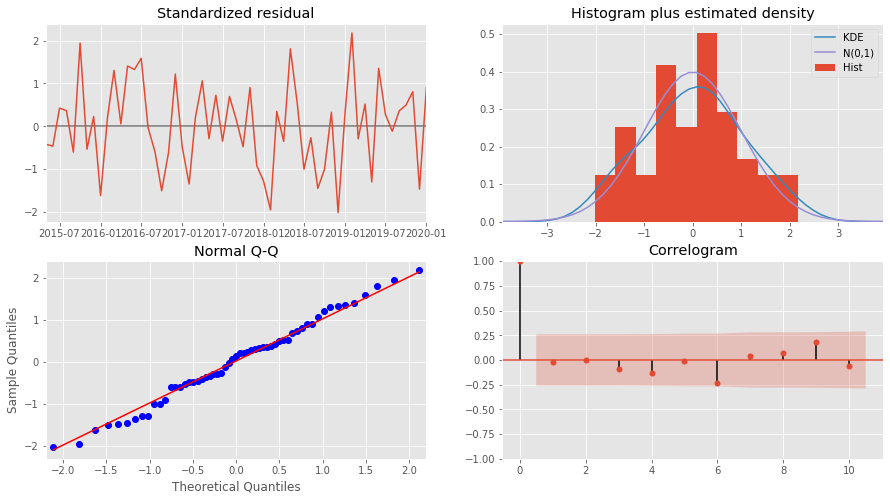

---------------------------------------------------------------
MAA Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -150.377
Date:                Sun, 02 Feb 2020   AIC                            304.755
Time:                        12:13:13   BIC                            308.875
Sample:                    02-01-2015   HQIC                           306.360
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0357      0.014      2.574      0.010       0.009       0.063
sigma2        10.4602      2.184      4.789      0.000 

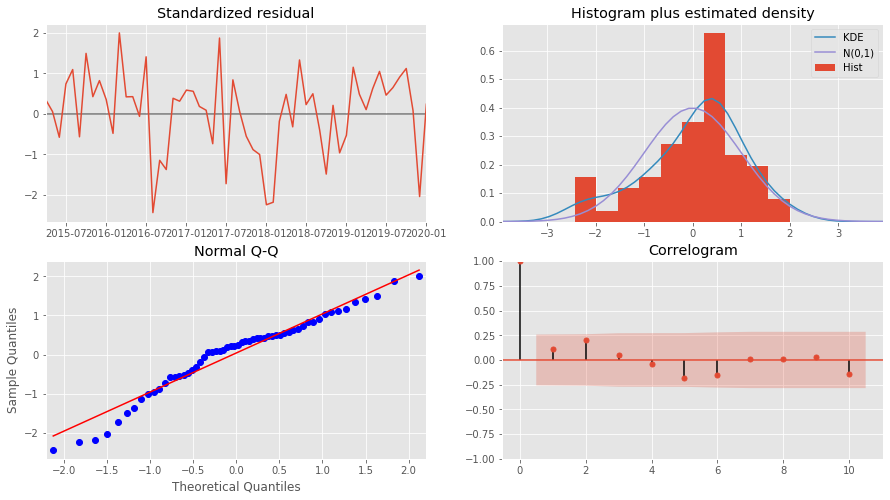

---------------------------------------------------------------
MGP Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -99.300
Date:                Sun, 02 Feb 2020   AIC                            204.599
Time:                        12:13:14   BIC                            210.728
Sample:                    02-01-2015   HQIC                           206.981
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0069      0.007      0.942      0.346      -0.007       0.021
ma.L1          0.0374      0.206      0.181      0.856 

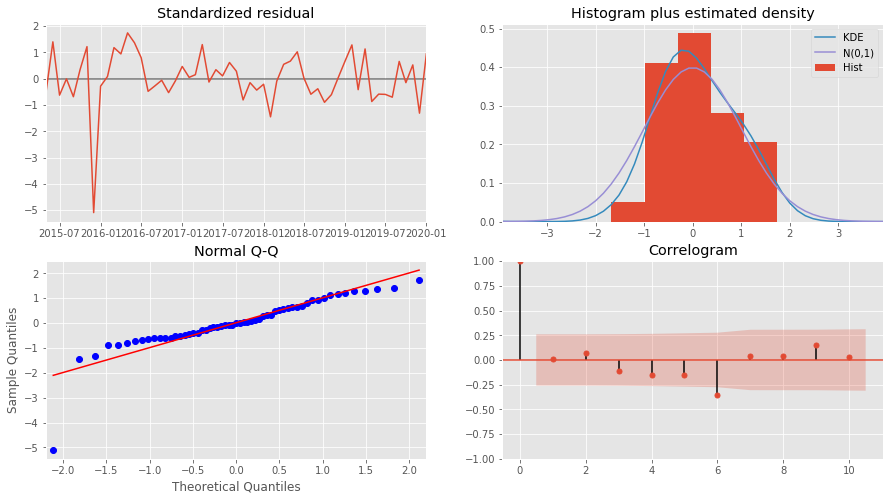

---------------------------------------------------------------
MPW Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -49.756
Date:                Sun, 02 Feb 2020   AIC                            105.511
Time:                        12:13:14   BIC                            111.693
Sample:                    02-01-2015   HQIC                           107.919
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0071      0.002      2.936      0.003       0.002       0.012
ar.L1          0.1087      0.174      0.623      0.533 

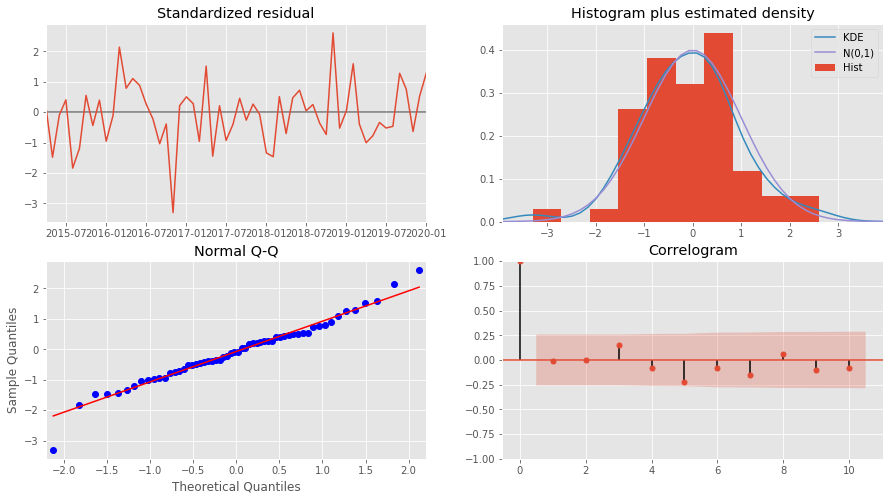

---------------------------------------------------------------
WY Summary                            Statespace Model Results                           
Dep. Variable:              Adj Close   No. Observations:                   60
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -104.013
Date:                Sun, 02 Feb 2020   AIC                            214.026
Time:                        12:13:15   BIC                            220.207
Sample:                    02-01-2015   HQIC                           216.434
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0017      0.007      0.267      0.789      -0.011       0.014
ar.L1          0.1877      0.153      1.229      0.219  

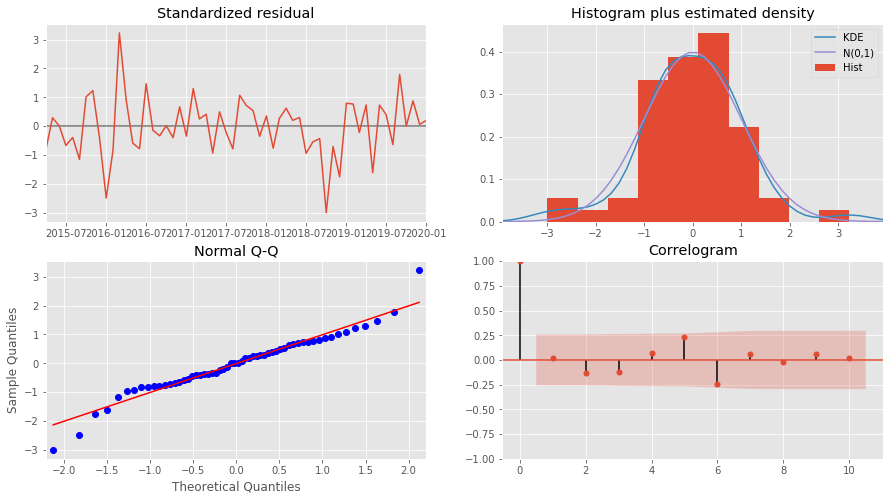

---------------------------------------------------------------


In [76]:
results_dict = {}
for key in reit_df_dict.keys():
    ts = reit_df_dict[key]
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(ts, order = best_parameters2[key], 
                                            enforce_stationarity = False,
                                            enforce_invertability = False,
                                            trend = 't')
    results = ARIMA_MODEL.fit()
    results_dict[key] = results
    print(f'{key} Summary {results.summary()}')
    print()
    print(f'{key} Diagnostics:')
    results.plot_diagnostics(figsize = (15,8))
    plt.show()
    print('---------------------------------------------------------------')